# <span style="color:red"> <U/> Similar Products Recommendation for Big basket Dataset</span>

###  Dataset Description

- Bigbasket is the largest online grocery supermarket in India. Was launched somewhere around in 2011 since then they've been expanding their business. Though some new competitors have been able to set their foot in the nation such as Blinkit etc. but BigBasket has still not loose anything - thanks to ever expanding popular base and their shift to online buying.


- The link for the dataset is 
<a href="url" target="_blank">https://www.kaggle.com/datasets/surajjha101/bigbasket-entire-product-list-28k-datapoints</a>



- There are 27555 rows in dataset , 
  The dataset contains 10 attributes (columns) with simple meaning and which are described as follows:
  
  
 | Column | Description |
 | :---  | :---  |
    | index |Simply the Index
	| product |Title of the product (as they're listed)-**23541 unique values**
	| category | Category into which product has been classified- **11 unique categories**
	| sub_category | Subcategory into which product has been kept-**90 unique sub_categories**
    | brand |Brand of the product- **2314 unique brands**
	| sale_price |Price at which product is being sold on the site
	| market_price |Market price of the product
	| type |Type into which product falls- **426 unique types**
	| rating |Rating the product has got from its consumers
	| description|Description of the product (in detail)




## Business Objective (Problem) and Constraints:

- To recommend products as much as similar (relevant) to the product searched in Big basket search query
- Incorrect recommendations could impact customer experience
- Low latency requirement


## ML problem formulation:

- It is a Item- Item based Collabarative Filtered recommender system problem
- Item based Collabarative Filtering Recommender system uses similarity between items as a measure to recommend similar items to the queried item


## Performance Metrics:

- Cosine similarity will be used to find similar items for the given query item using the item (product) details  while modelling
- Cosine similarity is a metric, helpful in determining, how similar the data objects(two products) are, In cosine similarity, data objects in a dataset are treated as a vector. The formula to find the cosine similarity between two vectors is 
       
    Cos(x, y) = x . y / ||x|| * ||y||
    
    where,
           x . y = product (dot) of the vectors ‘x’ and ‘y’.
          ||x|| and ||y|| = length of the two vectors ‘x’ and ‘y’.
          ||x|| * ||y|| = cross product of the two vectors ‘x’ and ‘y’

Source: https://www.geeksforgeeks.org/cosine-similarity/

- In Real time, metrics described above don’t show us how real customers react to the produced recommendations in terms of the company’s business strategy. The only way to measure it is A/B testing. A/B testing costs more resources and time, but it allows us to measure the model performance,One of techniques used in A/B testing is *`Click Through Rate(CTR)`*




### Overview Of Data

In [1]:
#import all the necessary packages.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from scipy.sparse import hstack
from sklearn.cluster import KMeans
from tqdm import tqdm

In [2]:
# we have give a csvfile which consists of all information about
# the products
# loading the data using pandas' read_csv file.
data=pd.read_csv(r'BigBasket Products.csv')
data.head(3)

index                                 product                category  \
0      1  Garlic Oil - Vegetarian Capsule 500 mg        Beauty & Hygiene   
1      2                   Water Bottle - Orange  Kitchen, Garden & Pets   
2      3          Brass Angle Deep - Plain, No.2    Cleaning & Household   

            sub_category              brand  sale_price  market_price  \
0              Hair Care  Sri Sri Ayurveda        220.0         220.0   
1  Storage & Accessories         Mastercook       180.0         180.0   
2            Pooja Needs                Trm       119.0         250.0   

                     type  rating  \
0        Hair Oil & Serum     4.1   
1  Water & Fridge Bottles     2.3   
2         Lamp & Lamp Oil     3.4   

                                         description  
0  This Product contains Garlic Oil that is known...  
1  Each product is microwave safe (without lid), ...  
2  A perfect gift for all occasions, be it your m...

In [3]:
print ('Number of data points : ', data.shape[0],'\nNumber of features/variables:', data.shape[1])

Number of data points :  27555 
Number of features/variables: 10


In [4]:
# each product/item has 10 features in the raw dataset.
data.columns # prints column-names or feature-names.

Index(['index', 'product', 'category', 'sub_category', 'brand', 'sale_price',
       'market_price', 'type', 'rating', 'description'],
      dtype='object')

In [5]:
# info about the data features
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27555 entries, 0 to 27554
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   index         27555 non-null  int64  
 1   product       27554 non-null  object 
 2   category      27555 non-null  object 
 3   sub_category  27555 non-null  object 
 4   brand         27554 non-null  object 
 5   sale_price    27555 non-null  float64
 6   market_price  27555 non-null  float64
 7   type          27555 non-null  object 
 8   rating        18929 non-null  float64
 9   description   27440 non-null  object 
dtypes: float64(3), int64(1), object(6)
memory usage: 2.1+ MB


In [6]:
# to know null values in each column/feature
data.isnull().sum()

index              0
product            1
category           0
sub_category       0
brand              1
sale_price         0
market_price       0
type               0
rating          8626
description      115
dtype: int64

Of these 10 features, we will be using only 7 features for our Model.

1.	product - Title of the product (as they're listed)-23541 unique values
2.	category - Category into which product has been classified-11 unique categories
3.	sub_category - Subcategory into which product has been kept-90 unique sub_categories
4.	brand - Brand of the product-2314 unique brands
5.	type- Type into which product falls-426 unique types
6.  sale_price - Price at which product is being sold on the site
7. description- Description of the product (in detail)

  In addition to the above 7 features we will use newly built feature **`discount`** on product(i.e, market price-sell price/market price*100) , to rank the order of Recommended products


In [7]:
# creating new column discount_%
data['discount_%']=(data['market_price']-data['sale_price'])/data['market_price'] *100

In [8]:
# selecting the required columns from dataframe for our analysis and model building
data=data[['product','category','sub_category','brand','type','description','sale_price','discount_%']]
data.head(2)

product                category  \
0  Garlic Oil - Vegetarian Capsule 500 mg        Beauty & Hygiene   
1                   Water Bottle - Orange  Kitchen, Garden & Pets   

            sub_category              brand                    type  \
0              Hair Care  Sri Sri Ayurveda         Hair Oil & Serum   
1  Storage & Accessories         Mastercook  Water & Fridge Bottles   

                                         description  sale_price  discount_%  
0  This Product contains Garlic Oil that is known...       220.0         0.0  
1  Each product is microwave safe (without lid), ...       180.0         0.0

In [9]:
# to find the row with product value null
data[data['product'].isna()]

product   category sub_category          brand           type  \
14363     NaN  Beverages       Coffee  Cothas Coffee  Ground Coffee   

                                             description  sale_price  \
14363  Cothas Specialty Blend Coffee and Chicory incl...       200.0   

       discount_%  
14363   16.666667

- we have 1 product with No product title
- will drop this product with no product title as it may be a erroneous point 

In [10]:
# we have 1 product with No product title
# will drop this product with no product title as it may be a erroneous point 
index_to_drop=data[data['product'].isna()].index # getting index of row with missing product title
data.drop(index_to_drop,inplace=True)


In [11]:
# to find the row with value null
data.isnull().any()

product         False
category        False
sub_category    False
brand            True
type            False
description      True
sale_price      False
discount_%      False
dtype: bool

In [12]:
# to find the row with brand value null
data[data['brand'].isna()]

product              category              sub_category  \
9765  Food Package - Medium  Cleaning & Household  Disposables, Garbage Bag   

     brand                       type description  sale_price  discount_%  
9765   NaN  Aluminium Foil, Clingwrap         NaN        50.0         0.0

- Will replace NaN Brand value by Most occuring(Mode) value in same category,sub_category and type of Product

In [13]:
data['brand'].describe()

count      27553
unique      2313
top       Fresho
freq         638
Name: brand, dtype: object

In [14]:
print(data[data['brand'].isna()]['category'].to_list()[0])
print(type(data[data['brand'].isna()]['category'].to_list()[0]))
print(data[data['brand'].isna()]['sub_category'])
print(data[data['brand'].isna()]['type'].to_list())


Cleaning & Household
<class 'str'>
9765    Disposables, Garbage Bag
Name: sub_category, dtype: object
['Aluminium Foil, Clingwrap']


In [15]:
# Will replace NaN Brand value by Most occuring(Mode) value in same category,sub_category and type of Product
#https://www.askpython.com/python-modules/pandas/conditionally-grouping-values
g=data.groupby(['category','sub_category','type'])['brand'] # grouping data by columns category,sub_category,type
g

In [16]:
# getting the brand values for grouped data for the column values with Brand =NaN
g.get_group((data[data['brand'].isna()]['category'].to_list()[0],data[data['brand'].isna()]['sub_category'].to_list()[0], \
              data[data['brand'].isna()]['type'].to_list()[0])).value_counts()

BB Home       5
Asahikasei    4
Oddy          3
Freshee       2
Ezee Alka     2
Glad          1
Multix        1
Aarika        1
Hindalco      1
Name: brand, dtype: int64

In [17]:
# will fill the most occuring Brand Value BB Home for missing Brand Value
data['brand'].replace(to_replace = np.NaN, value ='BB Home',inplace=True)

In [18]:
data.loc[9765] # after replacing missing Brand value

product             Food Package - Medium
category             Cleaning & Household
sub_category     Disposables, Garbage Bag
brand                             BB Home
type            Aluminium Foil, Clingwrap
description                           NaN
sale_price                             50
discount_%                              0
Name: 9765, dtype: object

In [19]:
data.isnull().any() # checking for any missing values 

product         False
category        False
sub_category    False
brand           False
type            False
description      True
sale_price      False
discount_%      False
dtype: bool

In [20]:
data.notnull().all()# checking for No  missing values 

product          True
category         True
sub_category     True
brand            True
type             True
description     False
sale_price       True
discount_%       True
dtype: bool

### EDA of selected features

In [21]:
data.columns

Index(['product', 'category', 'sub_category', 'brand', 'type', 'description',
       'sale_price', 'discount_%'],
      dtype='object')

In [22]:
# Univariate Analysis for feature 'product'
data['product'].describe()

count                            27554
unique                           23540
top       Turmeric Powder/Arisina Pudi
freq                                26
Name: product, dtype: object

- Out of 27554 there are 23540 Unique values for `product` and top most occuring product is 'Turmeric Powder/Arisina Pudi' with 26 times 

In [23]:
data['product'].value_counts()


Turmeric Powder/Arisina Pudi                                                   26
Extra Virgin Olive Oil                                                         15
Cow Ghee/Tuppa                                                                 14
Olive Oil - Extra Virgin                                                       12
Colorsilk Hair Colour With Keratin                                             12
                                                                               ..
Awadhi Kadhai Chicken Masala                                                    1
Unsweetened Peanut Butter \r\nCreamy                                            1
Aloevera & Wheatgrass Juice - Supports Detoxification, Digestion & Immunity     1
Diya & Batti - Small                                                            1
Mix - Vermicelli Payasam                                                        1
Name: product, Length: 23540, dtype: int64

In [24]:
d1=data['product'].value_counts().to_frame()
d1[d1['product']==1]


product
Papaya Fruit Facial Kit                                   1
Premium Round Plastic Container With Lid - Mult...        1
Powder - Organic Ground Cumin                             1
Kasamrita Herbal Syrup -  For Cough & Cold                1
Butter - Salted                                           1
...                                                     ...
Awadhi Kadhai Chicken Masala                              1
Unsweetened Peanut Butter \r\nCreamy                      1
Aloevera & Wheatgrass Juice - Supports Detoxifi...        1
Diya & Batti - Small                                      1
Mix - Vermicelli Payasam                                  1

[20566 rows x 1 columns]

- Out of 27554 products 20566 product occur only once

In [25]:
# Univariate Analysis For feature category
data['category'].describe()

count                27554
unique                  11
top       Beauty & Hygiene
freq                  7867
Name: category, dtype: object

In [26]:
d1=data['category'].value_counts().reset_index()
d1.columns=['category','counts']
d1

category  counts
0           Beauty & Hygiene    7867
1       Gourmet & World Food    4690
2     Kitchen, Garden & Pets    3580
3     Snacks & Branded Foods    2814
4   Foodgrains, Oil & Masala    2676
5       Cleaning & Household    2675
6                  Beverages     884
7      Bakery, Cakes & Dairy     851
8                  Baby Care     610
9        Fruits & Vegetables     557
10         Eggs, Meat & Fish     350

In [27]:
#https://www.w3schools.com/python/pandas/ref_df_cumsum.asp
#https://www.geeksforgeeks.org/how-to-rename-columns-in-pandas-dataframe/
cate=data['category'].value_counts(normalize=True).reset_index() # creating data frame with name cate for further processing
cate['cum_%']= cate['category'].cumsum()
cate.columns=['category','%','cum_%']
cate

category         %     cum_%
0           Beauty & Hygiene  0.285512  0.285512
1       Gourmet & World Food  0.170211  0.455723
2     Kitchen, Garden & Pets  0.129927  0.585650
3     Snacks & Branded Foods  0.102127  0.687777
4   Foodgrains, Oil & Masala  0.097118  0.784895
5       Cleaning & Household  0.097082  0.881977
6                  Beverages  0.032082  0.914060
7      Bakery, Cakes & Dairy  0.030885  0.944944
8                  Baby Care  0.022138  0.967083
9        Fruits & Vegetables  0.020215  0.987298
10         Eggs, Meat & Fish  0.012702  1.000000

- `28.55%` of products fall in category of `Beauty & Hygenie`
- Gourmet & World Food occupies 17.02 % of total products
- followed by Kitchen, Garden & Pets which has a 12.99% share
- Snacks & Branded Foods has 10.2% share
- Rest of the categories have less than 1 percent share each in total products list

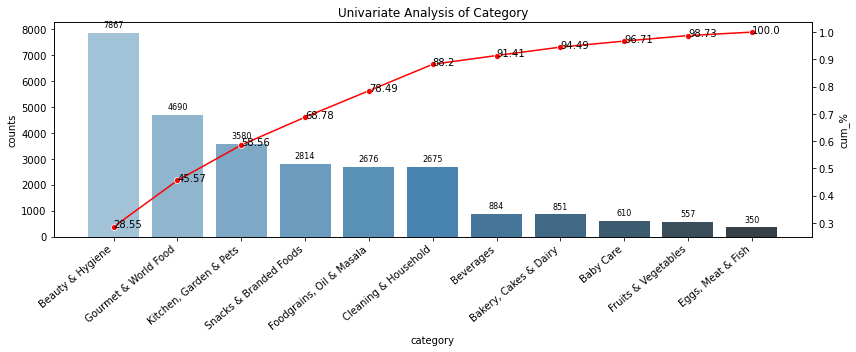

In [28]:
#https://stackoverflow.com/questions/37930693/how-can-i-make-a-barplot-and-a-lineplot-in-the-same-seaborn-plot-with-different
# we can combine line and bar graph in same plot using twinx() in seaborn
#https://www.geeksforgeeks.org/how-to-annotate-bars-in-barplot-with-matplotlib-in-python/
#https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html
#https://www.easytweaks.com/matplotlib-seaborn-text-label-points/
plt.figure(figsize=(12,5))
ax=sns.barplot(x='category',y='counts',data=d1,palette="Blues_d")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40,ha="right")
for bar in ax.patches: # annotating bar graph 
    ax.annotate(format(bar.get_height(), '.0f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=8, xytext=(0, 8),
                   textcoords='offset points')
    
ax2=ax.twinx() # to include line graph with bar graph in same plot
ax2=sns.lineplot(x='category',y='cum_%',data=cate,marker="o",color='r')

for i,value in enumerate(cate['cum_%'].values): # to annotate line plot 
    ax2.text(cate['category'].values[i],cate['cum_%'].values[i]-0.0025,np.round(value*100,2))
    # putting text of cum_% value with respect to its x,y values
    #ax2,text(x-coordinate,ycordinate,value) # position of annotation
ax.set_title('Univariate Analysis of Category') # title the graph
plt.tight_layout()
plt.show()

In [29]:
# For feature 'sub_category'
data['sub_category'].describe()

count         27554
unique           90
top       Skin Care
freq           2294
Name: sub_category, dtype: object

In [30]:
data['sub_category'].value_counts()

Skin Care                   2294
Health & Medicine           1133
Hair Care                   1028
Storage & Accessories       1015
Fragrances & Deos           1000
                            ... 
Mutton & Lamb                 20
Water                         17
Flower Bouquets, Bunches       8
Pork & Other Meats             5
Marinades                      1
Name: sub_category, Length: 90, dtype: int64

In [31]:
data['sub_category'].value_counts(normalize=True)*100 # To get percentage

Skin Care                   8.325470
Health & Medicine           4.111926
Hair Care                   3.730856
Storage & Accessories       3.683676
Fragrances & Deos           3.629237
                              ...   
Mutton & Lamb               0.072585
Water                       0.061697
Flower Bouquets, Bunches    0.029034
Pork & Other Meats          0.018146
Marinades                   0.003629
Name: sub_category, Length: 90, dtype: float64

- The top four major sub_categories are as follows

   1.Skin Care- 8.32%<br/>
   2.Health & Medicine- 4.11%<br/>
   3.Hair Care-3.73%<br/> 
   4.Storage & Accessories- 3.62%<br/> 

In [32]:
data['sub_category'].unique() # to get unique values of sub_category

array(['Hair Care', 'Storage & Accessories', 'Pooja Needs',
       'Bins & Bathroom Ware', 'Bath & Hand Wash', 'All Purpose Cleaners',
       'Skin Care', 'Mops, Brushes & Scrubs', 'Cooking & Baking Needs',
       'Chocolates & Biscuits', 'Fresheners & Repellents',
       'Snacks, Dry Fruits, Nuts', 'Dairy & Cheese',
       'Pasta, Soup & Noodles', 'Dry Fruits', 'Drinks & Beverages',
       'Kitchen Accessories', 'Flask & Casserole', 'Breakfast Cereals',
       'Frozen Veggies & Snacks', 'Fruit Juices & Drinks',
       'Cookies, Rusk & Khari', 'Fragrances & Deos', 'Tea',
       'Masalas & Spices', "Men's Grooming", 'Chocolates & Candies',
       'Steel Utensils', 'Tinned & Processed Food', 'Organic Staples',
       'Sauces, Spreads & Dips', 'Pickles & Chutney',
       'Ready To Cook & Eat', 'Baby Bath & Hygiene', 'Stationery',
       'Pet Food & Accessories', 'Biscuits & Cookies', 'Oral Care',
       'Snacks & Namkeen', 'Detergents & Dishwash', 'Crockery & Cutlery',
       'Cuts & Spro

In [33]:
#  top 10 sub_categories
subcategory_count=Counter(list(data['sub_category']))
subcategory_count.most_common(10)

[('Skin Care', 2294),
 ('Health & Medicine', 1133),
 ('Hair Care', 1028),
 ('Storage & Accessories', 1015),
 ('Fragrances & Deos', 1000),
 ('Bath & Hand Wash', 996),
 ('Crockery & Cutlery', 890),
 ('Masalas & Spices', 889),
 ('Snacks, Dry Fruits, Nuts', 840),
 ("Men's Grooming", 805)]

In [34]:
d1=data['sub_category'].value_counts().reset_index()[0:10] # selecting top 10 sub categories
d1.columns=['sub_category','counts'] # renaming colimns
d1

sub_category  counts
0                 Skin Care    2294
1         Health & Medicine    1133
2                 Hair Care    1028
3     Storage & Accessories    1015
4         Fragrances & Deos    1000
5          Bath & Hand Wash     996
6        Crockery & Cutlery     890
7          Masalas & Spices     889
8  Snacks, Dry Fruits, Nuts     840
9            Men's Grooming     805

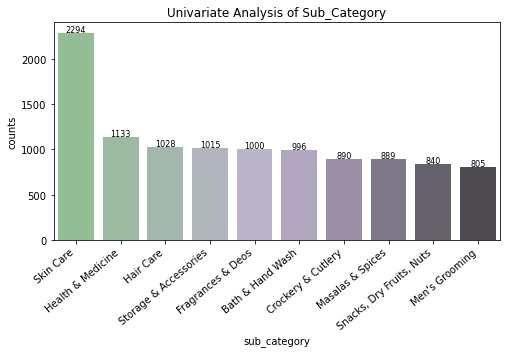

In [35]:
#ploting top 10 sub categories
#https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html
#https://matplotlib.org/stable/gallery/userdemo/annotate_explain.html?highlight=annot
plt.figure(figsize=(8,4))
ax=sns.barplot(x='sub_category',y='counts',data=d1,palette="Accent_d")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40,ha="right")

# annotating values
for bar in ax.patches: # annotating bar graph 
    ax.annotate(format(bar.get_height(), '.0f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=8, xytext=(0, 3.5),
                   textcoords='offset points')
ax.set_title('Univariate Analysis of Sub_Category') # title the graph

plt.show()

In [36]:
# For Feature 'Brand'
data['brand'].describe()

count      27554
unique      2313
top       Fresho
freq         638
Name: brand, dtype: object

In [37]:
#  top 10 brand
brand_count=Counter(list(data['brand']))
brand_count.most_common(10)

[('Fresho', 638),
 ('bb Royal', 539),
 ('BB Home', 429),
 ('DP', 250),
 ('Fresho Signature', 171),
 ('bb Combo', 168),
 ('Amul', 153),
 ('INATUR ', 146),
 ('Himalaya', 141),
 ('Dabur', 138)]

In [38]:
# percentage of top 10 brands
(data['brand'].value_counts(normalize=True)*100)[:10]

Fresho              2.315453
bb Royal            1.956159
BB Home             1.556943
DP                  0.907309
Fresho Signature    0.620600
bb Combo            0.609712
Amul                0.555273
INATUR              0.529869
Himalaya            0.511722
Dabur               0.500835
Name: brand, dtype: float64

- There are 2313 unique brands 
- The brand which has highest number of products is Fresho - 638 counts - 2.3%

In [39]:
# For Feature 'type'
data['type'].describe()

count         27554
unique          426
top       Face Care
freq           1508
Name: type, dtype: object

In [40]:
#  top 10 type of products
type_count=Counter(list(data['type']))
type_count.most_common(10)

[('Face Care', 1508),
 ('Ayurveda', 538),
 ("Men's Deodorants", 500),
 ('Shampoo & Conditioner', 461),
 ('Containers Sets', 415),
 ('Glassware', 415),
 ('Bathing Bars & Soaps', 390),
 ('Blended Masalas', 380),
 ('Body Care', 340),
 ('Gourmet Tea & Tea Bags', 335)]

In [41]:
# percentage of top 10 types
(data['type'].value_counts(normalize=True)*100)[:10]

Face Care                 5.472890
Ayurveda                  1.952530
Men's Deodorants          1.814619
Shampoo & Conditioner     1.673078
Glassware                 1.506133
Containers Sets           1.506133
Bathing Bars & Soaps      1.415402
Blended Masalas           1.379110
Body Care                 1.233941
Gourmet Tea & Tea Bags    1.215794
Name: type, dtype: float64

- There are 426 unique types of product 
- Face care is the top type of product with 1508 counts- 5.42%

### sale_price

In [42]:
#  top sale_price
saleprice_count=Counter(list(data['sale_price']))
saleprice_count.most_common(10)

[(99.0, 406),
 (199.0, 317),
 (50.0, 317),
 (299.0, 302),
 (150.0, 291),
 (60.0, 289),
 (149.0, 260),
 (225.0, 248),
 (120.0, 245),
 (75.0, 241)]

In [43]:
data['sale_price'].value_counts().sort_index(ascending=False)

12500.00     1
10090.00     1
8184.44      1
7999.00      1
7299.00      1
            ..
7.50         2
6.00         7
5.00        25
3.00         1
2.45         1
Name: sale_price, Length: 3256, dtype: int64

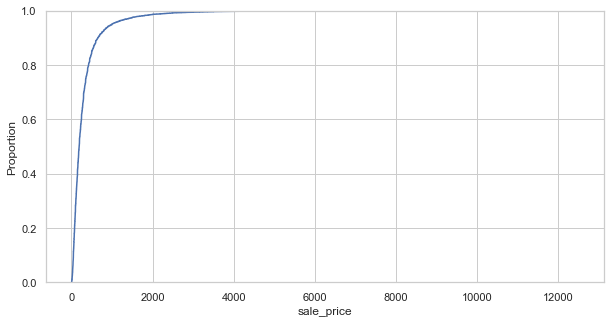

In [44]:
#CDF of sale_price
sns.set(rc={'figure.figsize':(10,5)})
sns.set_style('whitegrid')
sns.ecdfplot(data['sale_price'])

- 99% of products sale price is below 2000

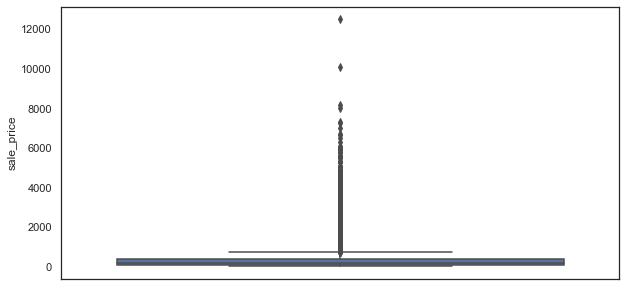

In [45]:
# Univariate analysis of sale_price
#Plotting of sale_price variable
sns.set(rc={'figure.figsize':(10,5)})
sns.set_style('white')
sns.boxplot(y=data['sale_price'])

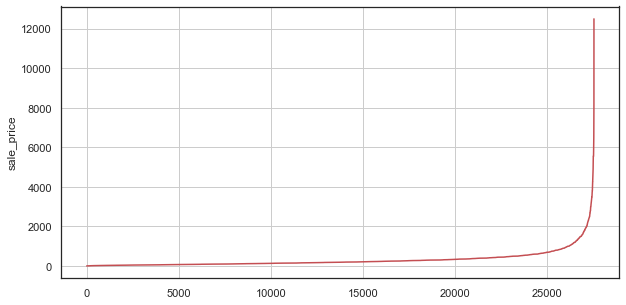

In [46]:
ypoints=np.array(data['sale_price'].sort_values())
plt.plot(ypoints,'r-')
plt.ylabel('sale_price')
plt.grid()
plt.show()

- From the above line plot there is a steep change at sale_price 2000(Inflection point)
- So will remove products whose sale_price is above 2000 

In [47]:
# data with sale price greater than 
data_saleprice=data[data['sale_price']>2000]
data_saleprice.shape

(390, 8)

In [48]:
data=data[data['sale_price']<=2000]
print("No. of data points after removing sale_price outliers:",data.shape[0])

No. of data points after removing sale_price outliers: 27164


In [49]:
data.to_csv(r'bigbasket_after_removing_outliers.csv') # saving to csv after removing data points with product value NaN and sale price greater than 5501

### Description feature

In [50]:
data['description'].value_counts()

A brand inspired by the Greek goddess of victory, it personifies strength, speed and energy and it launched its first perfume in 1929. Since then, a wide assortment of fragrance collections has hit the marketplace with refreshing, and eye-catching proposals that capture the essence and lifestyle of today´s man and woman.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [51]:
# to find number rows with no description
data['description'].isna().sum()

114

In [52]:
data[data['description'].isna()]

product  \
288            Arrabbiata Tomato Pasta Sauce With Chilli   
480    Pumice Stone & Emery Foot Filer - FFL3407, Col...   
780                               Peanut Butter - Chunky   
845         Squash - Sarasaparilla/Nannari/Sugandhi Root   
1047                   Natura Rice & Walnut Drink, Vegan   
...                                                  ...   
25510  BBPopular Almond/Badam Californian 500gm + BBR...   
25583  Chai/Chai/Tea/ Coffee Bone China Microwave Ser...   
26116             Tea Strainer - Stainless Steel, Medium   
26835                  Cold Pressed Virgin Groundnut Oil   
27303                            Zipper Storage - Gallon   

                       category              sub_category             brand  \
288        Gourmet & World Food    Sauces, Spreads & Dips         Montanini   
480            Beauty & Hygiene          Bath & Hand Wash              Kaiv   
780        Gourmet & World Food    Sauces, Spreads & Dips  American Garden    
845                   Beverages     Fruit Juices & Drinks        NaturoBell   
1047       Gourmet & World Food        Drinks & Beverages            BORGES   
...                         ...                       ...               ...   
25510  Foodgrains, Oil & Masala                Dry Fruits          bb Combo   
25583    Kitchen, Garden & Pets        Crockery & Cutlery         BP Bharat   
26116    Kitchen, Garden & Pets       Kitchen Accessories              Ritu   
26835  Foodgrains, Oil & Masala        Edible Oils & Ghee            Chekko   
27303      Cleaning & Household  Disposables, Garbage Bag              Glad   

                            type description  sale_price  discount_%  
288      Mustard & Cheese Sauces         NaN      325.00    0.000000  
480          Bathing Accessories         NaN      175.00    0.000000  
780     Chocolate, Peanut Spread         NaN      299.00    0.000000  
845        Syrups & Concentrates         NaN      140.00    0.000000  
1047               Health Drinks         NaN      275.01   21.200573  
...                          ...         ...         ...         ...  
25510                    Almonds         NaN      443.00   38.896552  
25583      Cups, Mugs & Tumblers         NaN      269.00   27.882038  
26116   Strainer, Ladle, Spatula         NaN       99.00   26.666667  
26835              Groundnut Oil         NaN      325.00    0.000000  
27303  Aluminium Foil, Clingwrap         NaN      350.00    0.000000  

[114 rows x 8 columns]

- There are 114 datapoints/ rows where description value is NaN
- we will replace NaN values of description with `product,category,sub_category,brand,type` column values

In [53]:
# replacing NaN values of description with product,category,sub_category,brand,type column values
indices_to_update=data[data['description'].isna()].index # getting index of row with NaN description title
for i in indices_to_update:
    data['description'].loc[i]=(data['product']+" "+data['category']+" "+data['sub_category']+" "+data['brand']+" "+ \
                                data['type']).loc[i]

In [54]:
data.isnull().any() # checking for any missing values 

product         False
category        False
sub_category    False
brand           False
type            False
description     False
sale_price      False
discount_%      False
dtype: bool

## Data Preprocessing

### Product Title

In [55]:
# we use the list of stop words that are downloaded from nltk lib.
import nltk # to download only once
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
print ('list of stop words:', stop_words)

list of stop words: {"shouldn't", 'if', 'she', 'against', 'into', 'hasn', 'won', 'has', 'hadn', 'during', 've', 'does', 'where', "weren't", 'him', 'but', 'from', 'weren', 'shouldn', 'above', 'our', 'wouldn', 'doesn', "couldn't", "wasn't", 'were', 'he', 'out', 'other', 'only', 'we', 'o', "should've", 'ain', 'is', 'their', 'wasn', 'with', 'them', "you've", 'in', 'needn', 'theirs', 'herself', 'did', 'here', 'hers', 'the', 'just', 'why', 'what', 'about', 't', "mustn't", "aren't", 'having', "needn't", 'below', 'most', 'isn', 'your', 'be', 'through', 'those', 'yours', 'then', 'because', "you'd", 'such', 'further', 'to', 'm', 'for', 'these', 'haven', 'you', 'some', 'too', 'they', 'll', 'all', 'yourselves', "it's", "hasn't", 'yourself', 'his', 'that', 'are', 'by', 'any', 'few', "that'll", 'being', 'couldn', 'before', 're', 'shan', 'doing', 'or', 'after', "didn't", 'than', 'y', 'on', "wouldn't", "you're", 'will', 'mustn', 'more', 'while', "don't", 'until', 'both', 'my', 'at', 'didn', 'each', 'o

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


In [56]:
# preprocessing product title
from tqdm import tqdm
import re
def preprocess_product(text):
    """ Function which does preprocesiing on prodcut title feature,
        removes stopwords, replaces special character with space, converts to lower case,
    """
    preprocessed_product=[]
    for title in tqdm(text):
        
        title = re.sub('[^A-Za-z]+', ' ', title) # remove all characters except a-z and A-Z
        # https://gist.github.com/sebleier/554280
        title = ' '.join(word for word in title.split() if title.lower() not in stop_words) # removing stop words
        title = ' '.join(word for word in title.split() if len(word)>2) # removing single letter and two letter words
        title = title.lower().strip()
        preprocessed_product.append(title)
        
    return preprocessed_product

In [57]:
# preprocessing product title
preprocessed_product=preprocess_product(data['product'].values)


100%|█████████████████████████████████| 27164/27164 [00:00<00:00, 54632.98it/s]


In [58]:
# replacing product column values with preprocessed product values
data['product']=preprocessed_product

### Category feature

In [59]:
# preprocressing category feature
## https://stackoverflow.com/questions/36383821/pandas-dataframe-apply-function-to-column-strings-based-on-other-column-value
data['category']=data['category'].str.replace('&','_') # replacing & with _
data['category']=data['category'].str.replace(',','_') # replacing , with _
data['category']=data['category'].str.replace("'",'') #replacing '' with ''(no space)
data['category']=data['category'].str.replace(" ",'') # removing white spaces
data['category']=data['category'].str.lower() # to lower case
data['category']=data['category'].str.strip() # removing trailing and leading white spaces

In [60]:
data['category'].unique()

array(['beauty_hygiene', 'kitchen_garden_pets', 'cleaning_household',
       'gourmet_worldfood', 'foodgrains_oil_masala',
       'snacks_brandedfoods', 'beverages', 'bakery_cakes_dairy',
       'babycare', 'fruits_vegetables', 'eggs_meat_fish'], dtype=object)

### Sub_Category feature

In [61]:
# preprocressing sub_category feature
data['sub_category']=data['sub_category'].str.replace('&','_') # replacing & with _
data['sub_category']=data['sub_category'].str.replace(',','_') # replacing , with _
data['sub_category']=data['sub_category'].str.replace("'",'') #replacing '' with ''(no space)
data['sub_category']=data['sub_category'].str.replace(" ",'') # removing white spaces
data['sub_category']=data['sub_category'].str.lower() # to lower case


In [62]:
data['sub_category'].unique()

array(['haircare', 'storage_accessories', 'poojaneeds',
       'bins_bathroomware', 'bath_handwash', 'allpurposecleaners',
       'skincare', 'mops_brushes_scrubs', 'cooking_bakingneeds',
       'chocolates_biscuits', 'fresheners_repellents',
       'snacks_dryfruits_nuts', 'dairy_cheese', 'pasta_soup_noodles',
       'dryfruits', 'drinks_beverages', 'kitchenaccessories',
       'flask_casserole', 'breakfastcereals', 'frozenveggies_snacks',
       'fruitjuices_drinks', 'cookies_rusk_khari', 'fragrances_deos',
       'tea', 'masalas_spices', 'mensgrooming', 'chocolates_candies',
       'steelutensils', 'tinned_processedfood', 'organicstaples',
       'sauces_spreads_dips', 'pickles_chutney', 'readytocook_eat',
       'babybath_hygiene', 'stationery', 'petfood_accessories',
       'biscuits_cookies', 'oralcare', 'snacks_namkeen',
       'detergents_dishwash', 'crockery_cutlery', 'cuts_sprouts',
       'health_medicine', 'cookware_nonstick', 'dairy', 'femininehygiene',
       'diapers_wip

In [63]:
data['sub_category'].nunique()

90

### Brand Feature

In [64]:
# preprocressing brand feature
data['brand']=data['brand'].str.replace('&','_') # replacing & with _
data['brand']=data['brand'].str.replace(',','_') # replacing , with _
data['brand']=data['brand'].str.replace("'",'') #replacing ' with ''(no space)
data['brand']=data['brand'].str.replace(" ",'') # removing white spaces
data['brand']=data['brand'].str.lower() # to lower case

In [65]:
data['brand'].value_counts()

fresho             638
bbroyal            539
bbhome             429
dp                 248
freshosignature    171
                  ... 
tatateagemini        1
godrejnupur          1
sachamoti            1
gomutra              1
cleanplanet          1
Name: brand, Length: 2276, dtype: int64

- Brand unique value after preprocessing is 2276 compared to original 2313, which means 12 brand were same except for some special characters of upper case

### Type Feature

In [66]:
# preprocressing brand feature
data['type']=data['type'].str.replace('&','_') # replacing & with _
data['type']=data['type'].str.replace(',','_') # replacing , with _
data['type']=data['type'].str.replace("'",'') #replacing '' with ''(no space)
data['type']=data['type'].str.replace(" ",'') # removing white spaces
data['type']=data['type'].str.lower() # to lower case

In [67]:
data['type'].value_counts()

facecare               1489
ayurveda                537
mensdeodorants          492
shampoo_conditioner     461
containerssets          415
                       ... 
specialty                 1
marinatedmeat             1
bagels_baguette           1
organiceggs               1
turkey_duck               1
Name: type, Length: 425, dtype: int64

### Description Feature

In [68]:
# preprocessing description
#https://stackoverflow.com/questions/30129936/python-regex-replace-sentence-with-starting-word
#https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python
from tqdm import tqdm
import re
def preprocess_description(text):
    """ Function which does preprocesiing on prodcut title feature,
        removes stopwords, replaces special character with space, converts to lower case,
    """
    preprocessed_description=[]
    for description in tqdm(text):
        
        #Delete all the data which are present in the brackets
        description = re.sub(r'\([^()]*\)',' ',description)
        # removing sentences which gives url link like'For Beauty tips, tricks & more visit https://bigbasket.blog/ '
        #description = re.sub(r'(For)+([\s\S]*?)(https\S+)',' ',description)
        #removing urls
        description = re.sub(r'http\S+',' ',description)
        description = re.sub('[^A-Za-z]+', ' ', description) # remove all characters except a-z and A-Z and replace with white space
        # https://gist.github.com/sebleier/554280
        description = ' '.join(word for word in description.split() if description.lower() not in stop_words) # removing stop words
        description = ' '.join(word for word in description.split() if len(word)>2) # removing single letter and two letter words
        description = description.lower().strip()
        preprocessed_description.append(description)
        
    return preprocessed_description

In [69]:
preprocessed_description=preprocess_description(data['description'].values)

100%|██████████████████████████████████| 27164/27164 [00:08<00:00, 3227.28it/s]


In [70]:
data['description']=preprocessed_description

In [71]:
print('Printing some random description values')
print('-'*50)
print('[9]',data['description'][9])
print('-'*50)
print('[288]',data['description'][288])
print('-'*50)
print('[457]',data['description'][457])
print('-'*50)

Printing some random description values
--------------------------------------------------
[9] scotch brite anti bacterial scrub pad thoroughly cleanses dishes and keeps the kitchen utensils squeaky clean with pleasant neem fragrance the scrub gentle the hands and does not wear off easily while eliminating bacteria and making your utensils sparkle and look good new with every wash
--------------------------------------------------
[288] arrabbiata tomato pasta sauce with chilli gourmet world food sauces spreads dips montanini mustard cheese sauces
--------------------------------------------------
[457] per energy kcal carbohydrate protein fat
--------------------------------------------------


In [72]:
print('Printing some random description values')
print('-'*50)
print('[625]',data['description'][625])
print('-'*50)
print('[1665]',data['description'][1665])
print('-'*50)
print('[2011]',data['description'][2011])
print('-'*50)

Printing some random description values
--------------------------------------------------
[625] for sensitive problem prone skin use regular skin care products may the root your problems dabur gulabari cold cream the safer natural face cream option with rose oil and glycerin that protect your skin against damage remove dryness dullness and hydrate from within for healthy and radiant rose like skin glow for beauty tips tricks more visit
--------------------------------------------------
[1665] our tea virtuosos have brought you incredibly tasty and purposeful blend that packs perfect symphony unmatched freshness the creamy vanilla flavour and earthy goodness the brewed liquor full bodied and velvety one boasts lush creamy aroma with humbling earthy notes the background the stone ground japanese matcha tea the liquor starts out robust yet enchanting creamy nutty flavour the premium madagascar vanilla which engulfs you from the first sip the luscious vanilla flavour met with fresh vegeta

In [73]:
data.head()

product             category  \
0                      garlic oil vegetarian capsule       beauty_hygiene   
1                                water bottle orange  kitchen_garden_pets   
2                             brass angle deep plain   cleaning_household   
3  cereal flip lid container storage jar assorted...   cleaning_household   
4                     creme soft soap for hands body       beauty_hygiene   

          sub_category           brand                    type  \
0             haircare  srisriayurveda           hairoil_serum   
1  storage_accessories      mastercook     water_fridgebottles   
2           poojaneeds             trm            lamp_lampoil   
3    bins_bathroomware          nakoda  laundry_storagebaskets   
4        bath_handwash           nivea       bathingbars_soaps   

                                         description  sale_price  discount_%  
0  this product contains garlic oil that known he...       220.0    0.000000  
1  each product microwave safe refrigerator safe ...       180.0    0.000000  
2  perfect gift for all occasions your mother sis...       119.0   52.400000  
3  multipurpose container with attractive design ...       149.0   15.340909  
4  nivea creme soft soap gives your skin the best...       162.0    0.000000

In [74]:
data.isna().sum() # to check any nan values

product         0
category        0
sub_category    0
brand           0
type            0
description     0
sale_price      0
discount_%      0
dtype: int64

In [75]:
print ('Number of data points after all preprocessing : ', data.shape[0],'\nNumber of features/variables:', data.shape[1])

Number of data points after all preprocessing :  27164 
Number of features/variables: 8


In [76]:
data.to_csv('preprocessed.csv',index=False) # saving preprocessed data to csv file 

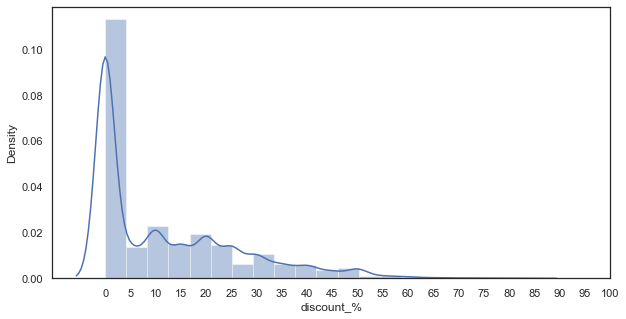

In [77]:
# Univariate analysis of discount_%
#Plotting of discount_% variable
sns.set(rc={'figure.figsize':(10,5)})
sns.set_style('white')
g=sns.distplot(data['discount_%'],bins=20)
g.set_xticks(np.arange(0,101,5))

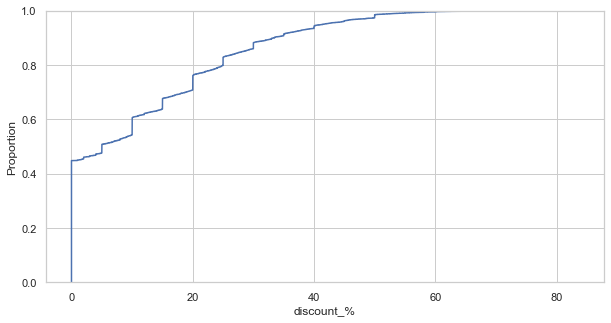

In [78]:
#CDF of discount_%
sns.set(rc={'figure.figsize':(10,5)})
sns.set_style('whitegrid')
sns.ecdfplot(data['discount_%'])

- Approx 46% of products have No discount(zero discount)
- Maximum discount for a product is 60% which is only for a small potion of total products(i.e,~1%)
- ~ 30% of products have discount from 1 to 20%
- ~ 10% of products have discount in range of 21-40% of market_price

### <u/> Clustering Analysis 

- Will do clustering analysis to find similar cluster of products using the features with text information **product(title),description** 

In [2]:
# loading preprocessed data
df=pd.read_csv(r'preprocessed.csv')
df.head(2)

product             category         sub_category  \
0  garlic oil vegetarian capsule       beauty_hygiene             haircare   
1            water bottle orange  kitchen_garden_pets  storage_accessories   

            brand                 type  \
0  srisriayurveda        hairoil_serum   
1      mastercook  water_fridgebottles   

                                         description  sale_price  discount_%  
0  this product contains garlic oil that known he...       220.0         0.0  
1  each product microwave safe refrigerator safe ...       180.0         0.0

In [3]:
# one hot encoding of product title (preprocessed product title)
vectorizer=CountVectorizer()
product_ohe=vectorizer.fit_transform(df['product'].values)

print("After One Hot Encoding")
print(product_ohe.shape)
print('No. of words in vectorizer dictionary:',len(vectorizer.get_feature_names()))

After One Hot Encoding
(27164, 8687)
No. of words in vectorizer dictionary: 8687


In [4]:
# computing sentiment score for description feature
import nltk
nltk.download('vader_lexicon')  

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Muheebpashasnr\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [5]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm import tqdm
sia=SentimentIntensityAnalyzer()

# saving sentiment scores in list 
negative=[]
neu=[]
pos=[]
compound=[]

for description in tqdm(df['description']):
    i=sia.polarity_scores(description)['neg']
    j=sia.polarity_scores(description)['neu']
    k=sia.polarity_scores(description)['pos']
    l=sia.polarity_scores(description)['compound']
    negative.append(i)
    neu.append(j)
    pos.append(k)
    compound.append(l)

100%|███████████████████████████████████| 27164/27164 [02:01<00:00, 223.00it/s]


In [6]:
# adding sentiment intensity analyser scores to dataframe as columns
df['negative']=negative
df['neutral']=neu
df['positive']=pos
df['compound']=compound

In [7]:
df.head(2)

product             category         sub_category  \
0  garlic oil vegetarian capsule       beauty_hygiene             haircare   
1            water bottle orange  kitchen_garden_pets  storage_accessories   

            brand                 type  \
0  srisriayurveda        hairoil_serum   
1      mastercook  water_fridgebottles   

                                         description  sale_price  discount_%  \
0  this product contains garlic oil that known he...       220.0         0.0   
1  each product microwave safe refrigerator safe ...       180.0         0.0   

   negative  neutral  positive  compound  
0     0.046    0.673     0.281    0.8271  
1     0.000    0.696     0.304    0.9432

In [9]:
df.to_csv(r'preprocessed_with_sentimentscore.csv') # saving to csv file

In [8]:
# concatenating product one hot encode feature, sentiment scores of description,sale_price,discount_% for clustering analysis
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X = hstack((product_ohe,df['sale_price'].values.reshape(-1,1),df['discount_%'].values.reshape(-1,1), \
           df['negative'].values.reshape(-1,1),df['neutral'].values.reshape(-1,1), \
           df['positive'].values.reshape(-1,1),df['compound'].values.reshape(-1,1))).tocsr()

In [9]:
X.shape

(27164, 8693)

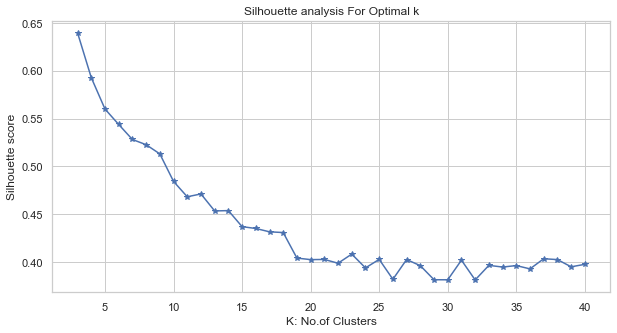

Wall time: 31min 25s


In [87]:
%%time
# performing clustering using Kmeans 
#https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score
#https://scikit-learn.org/stable/modules/clustering.html
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score # to evaluate clustering performance
silhouette_scr=[]
K=range(3,41)
for k in K:
    kmeans=KMeans(n_clusters=k,n_init=12,max_iter=200) # setting KMeans cluster with 12 different centriod initializations & 200 iterations for a single run
    kmeans=kmeans.fit(X)
    labels=kmeans.labels_
    
    # silhouette score
    silhouette_scr.append(silhouette_score(X,labels))

plt.plot(K,silhouette_scr,'b*-')
plt.xlabel('K: No.of Clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette analysis For Optimal k')
plt.show()

- For a good clustering silhouette score should be as close as to 1, but in our case the K with maximum silhouette score is 3, for optimum number of clusters will choose 15 as best_k by elbow method

In [10]:
# will group data into 15 clusters
best_k=15
kmeans=KMeans(n_clusters=best_k,n_init=12,max_iter=200) # setting KMeans cluster with 12 different centriod initializations & 200 iterations for a single run
kmeans=kmeans.fit(X)

In [13]:
labels15=kmeans.labels_ # labels for each product given by clustering model
len(labels15)

27164

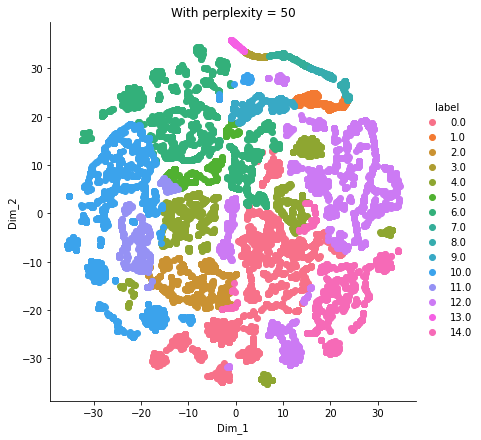

In [17]:
#visualising clusters using tsne
#https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
#https://plotly.com/python/t-sne-and-umap-projections/

# tsne for clustering with 15 clusters
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0,perplexity=50,n_iter=500) 

projections=tsne.fit_transform(X)

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((projections.T, labels15)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 50')
plt.show()

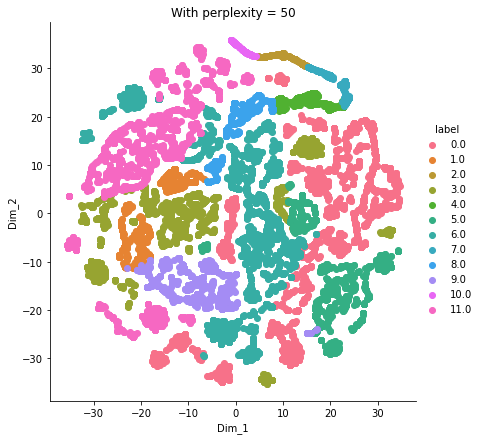

In [18]:
# will check for 12 clusters 
kmeans=KMeans(n_clusters=12,n_init=12,max_iter=200) # setting KMeans cluster with 12 different centriod initializations & 200 iterations for a single run
kmeans=kmeans.fit(X)

labels12=kmeans.labels_ # labels for each product given by clustering model

# tsne for clustering with 15 clusters
tsne = TSNE(n_components=2, random_state=0,perplexity=50,n_iter=500) 

projections=tsne.fit_transform(X)

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((projections.T, labels12)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 50')
plt.show()


- As observed clusters are less overlapping for 15 clusters than 12 clusters, though there are two to three clusters which are scattered and are at different densities at different orientations, will go with clutering the data into 15 groups(clusters)

- In Kmeans with K=15 , there is less overlap and clusters are dense and same cluster points are close to each other,except for cluster no 12 which is spread unevenly


In [19]:
# creating new column with  label 
df['cluster_label']=labels15
df.head(2)

product             category         sub_category  \
0  garlic oil vegetarian capsule       beauty_hygiene             haircare   
1            water bottle orange  kitchen_garden_pets  storage_accessories   

            brand                 type  \
0  srisriayurveda        hairoil_serum   
1      mastercook  water_fridgebottles   

                                         description  sale_price  discount_%  \
0  this product contains garlic oil that known he...       220.0         0.0   
1  each product microwave safe refrigerator safe ...       180.0         0.0   

   negative  neutral  positive  compound  cluster_label  
0     0.046    0.673     0.281    0.8271             10  
1     0.000    0.696     0.304    0.9432              6

### Checking cluster no.12 points

In [20]:
df[df['cluster_label']==12]

product               category  \
6                                multani mati         beauty_hygiene   
9            scrub pad anti bacterial regular     cleaning_household   
15     dove plastic soap case assorted colour     cleaning_household   
21       instant noodles chicken satay flavor      gourmet_worldfood   
27                    flaxseed pesticide free  foodgrains_oil_masala   
...                                       ...                    ...   
27146      notebook king size four line ruled     cleaning_household   
27152         popcorn french butter pink salt      gourmet_worldfood   
27156                           powder baking    snacks_brandedfoods   
27158                      papad garlic disco    snacks_brandedfoods   
27160                                rosemary      gourmet_worldfood   

                sub_category        brand                     type  \
6                   skincare    satinance                 facecare   
9        mops_brushes_scrubs  scotchbrite   utensilscrub-pad_glove   
15         bins_bathroomware       nakoda     soapcases_dispensers   
21        pasta_soup_noodles         koka          importednoodles   
27                 dryfruits  safeharvest           otherdryfruits   
...                      ...          ...                      ...   
27146             stationery    classmate  notebooks_files_folders   
27152  snacks_dryfruits_nuts       4700bc           gourmetpopcorn   
27156        readytocook_eat      kwality               homebaking   
27158        readytocook_eat        atish        papads_readytofry   
27160    cooking_bakingneeds     puramate    herbs_seasonings_rubs   

                                             description  sale_price  \
6      satinance multani matti excellent skin toner a...        58.0   
9      scotch brite anti bacterial scrub pad thorough...        20.0   
15     this soap case made virgin plastic which makes...        49.0   
21     koka instant noodles are known for their caref...        45.0   
27     super nutritious and good for your heart flaxs...        53.9   
...                                                  ...         ...   
27146  classmate notebooks are made the highest quali...        47.0   
27152  high quality mushroom corn popped olive oil fr...        31.5   
27156  kwality baking powder directions for use use k...        38.0   
27158  papads are prepared from urad dal flour and sp...        61.0   
27160  puramate rosemary enough transform dish into s...        67.5   

       discount_%  negative  neutral  positive  compound  cluster_label  
6        0.000000     0.095    0.592     0.313    0.8807             12  
9        0.000000     0.075    0.673     0.252    0.8824             12  
15      16.949153     0.000    0.739     0.261    0.8720             12  
21      10.000000     0.000    0.806     0.194    0.9062             12  
27       2.000000     0.000    0.805     0.195    0.9432             12  
...           ...       ...      ...       ...       ...            ...  
27146    2.083333     0.024    0.675     0.301    0.9756             12  
27152   10.000000     0.000    0.740     0.260    0.9300             12  
27156    0.000000     0.000    0.870     0.130    0.7717             12  
27158    0.000000     0.000    0.846     0.154    0.4588             12  
27160   10.000000     0.000    0.770     0.230    0.9217             12  

[4528 rows x 13 columns]

In [22]:
df[df['cluster_label']==12]['category'].value_counts()

snacks_brandedfoods      1126
foodgrains_oil_masala     803
beauty_hygiene            621
cleaning_household        519
fruits_vegetables         445
gourmet_worldfood         419
bakery_cakes_dairy        283
beverages                 139
kitchen_garden_pets       137
babycare                   19
eggs_meat_fish             17
Name: category, dtype: int64

- Cluster12 has products in multiple category with some outliers like babycare,but majority belongs to eatable products like snacks_brandedfoods,fruits_vegetables,foodgrains_oil_masala 
- There is also a good share of beauty_hygiene products which grouped into cluster12

In [23]:
df[df['cluster_label']==12][df['category']=='babycare'] # checking for products in cluster12 with babycare category

product  category       sub_category  \
830                         baby wipes gentle  babycare      diapers_wipes   
8323        bottle nipple cleaning brush pink  babycare   babybath_hygiene   
8986                  baby milk soap mildness  babycare   babybath_hygiene   
11365            baby soap extra moisturizing  babycare   babybath_hygiene   
12044                       santoor baby soap  babycare   babybath_hygiene   
12147                             baby powder  babycare   babybath_hygiene   
12900                 new medium diaper pants  babycare      diapers_wipes   
13138             new dry large diapers pants  babycare      diapers_wipes   
14075     moisture rich jasmine soap for moms  babycare  mothers_maternity   
14993                       toothbrush junior  babycare   babybath_hygiene   
16685           nourishing baby wellness soap  babycare   babybath_hygiene   
16911                       rich moisture bar  babycare   babybath_hygiene   
16939                 baby dry medium diapers  babycare      diapers_wipes   
16986           silicone teether apple orange  babycare    babyaccessories   
17301                   new born diaper pants  babycare      diapers_wipes   
19306  soft baby wipes with green tea essence  babycare      diapers_wipes   
21685        moisture rich rose soap for moms  babycare  mothers_maternity   
25042                           baby hair oil  babycare   babybath_hygiene   
25917                      sparkle brush pink  babycare    babyaccessories   

                    brand                    type  \
830          himalayababy               babywipes   
8323   morisonsbabydreams            babyoralcare   
8986         johnsonsbaby                babybath   
11365        himalayababy                babybath   
12044             santoor                babybath   
12147        himalayababy              babypowder   
12900             pampers                 diapers   
13138             pampers                 diapers   
14075            himalaya   maternitypersonalcare   
14993           patanjali            babyoralcare   
16685              meemee                babybath   
16911            babydove                babybath   
16939             pampers                 diapers   
16986  morisonsbabydreams       soothers_teethers   
17301             pampers                 diapers   
19306            mamypoko               babywipes   
21685            himalaya   maternitypersonalcare   
25042        johnsonsbaby         babyoil_shampoo   
25917  morisonsbabydreams  combs_brushes_clippers   

                                             description  sale_price  \
830    cleanses moisturizes and keeps the delicate ba...        44.0   
8323   morisons baby dreams bottle and nipple cleanin...        50.0   
8986   johnsons baby soap cleanse your babys face and...        55.0   
11365  ean code manufactured marketed the himalaya dr...        50.0   
12044  new santoor baby has perfect blend milk cream ...        39.2   
12147  himalaya offers yielding and cool baby powder ...        53.0   
12900  pampers baby dry pants style diapers are the o...        24.0   
13138  pampers dry pants style diapers are the only p...        28.0   
14075  himalaya for moms moisture rich jasmine soap s...        55.0   
14993  for healthy clean and shiny teeth use patanjal...        15.0   
16685  your little one needs utmost care right from b...        49.0   
16911  the first few months our babys skin continuall...        52.0   
16939  pampers disposable diapers pads with magic gel...        68.0   
16986  this morisons baby dreams silicone teether soo...        50.0   
17301  new pampers baby dry pants style diapers have ...        18.0   
19306  mamypoko soft baby wipes come with antibacteri...        49.0   
21685  himalaya for moms moisture rich rose soap spec...        55.0   
25042  johnsons baby hair oil enriched with avocado p...        55.0   
25917  this morisons baby dreams bottle and nipp

In [91]:
df.to_csv(r'preprocessed_with_clusterlabel.csv') # saving to csv file

cluster: 0


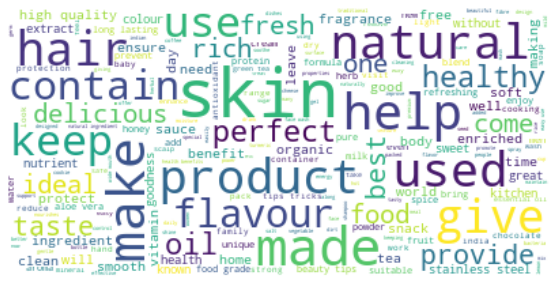

cluster: 1


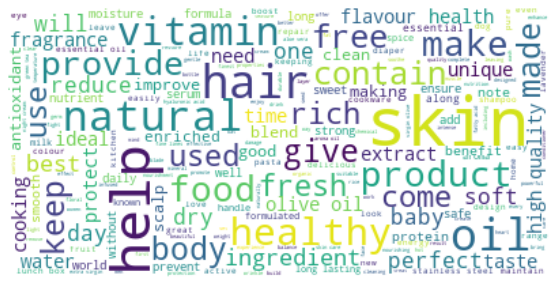

cluster: 2


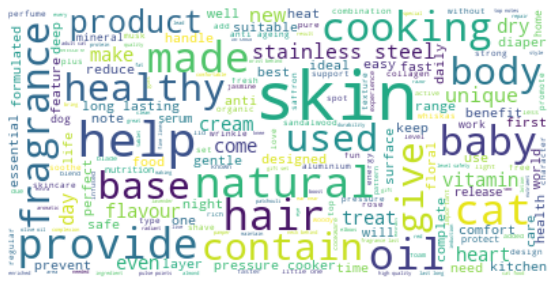

cluster: 3


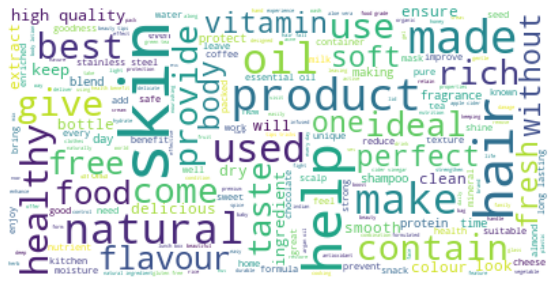

cluster: 4


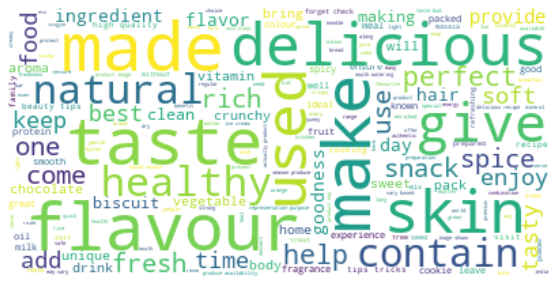

cluster: 5


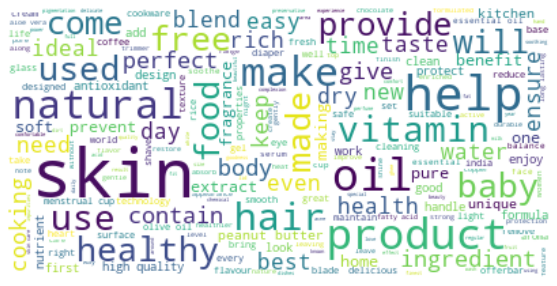

cluster: 6


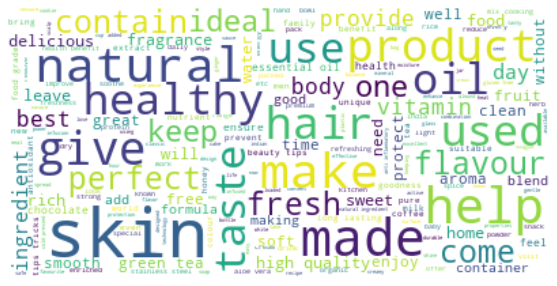

cluster: 7


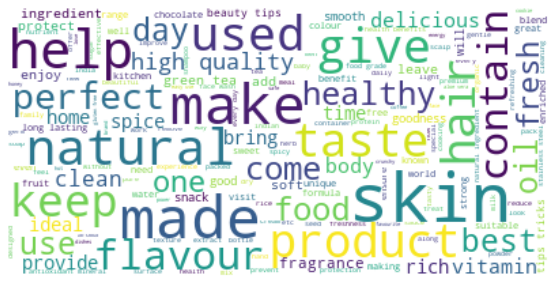

cluster: 8


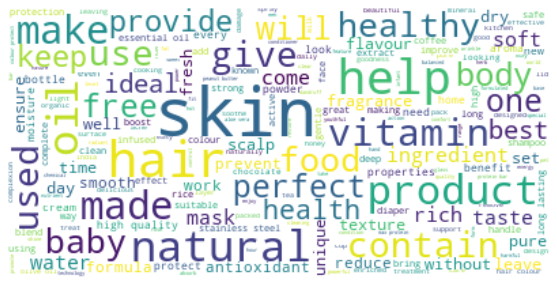

cluster: 9


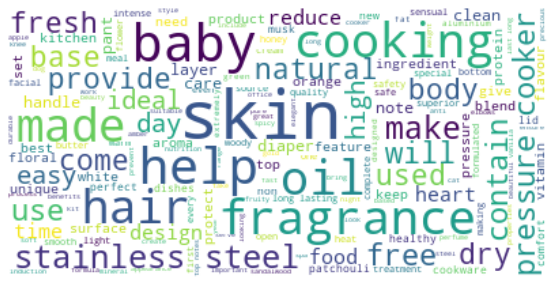

cluster: 10


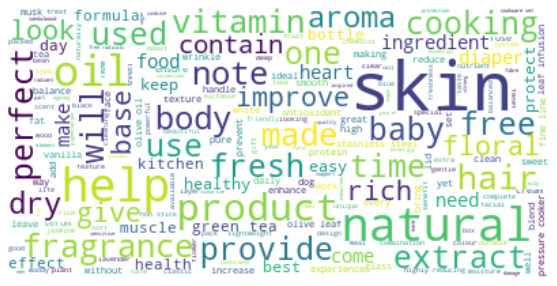

cluster: 11


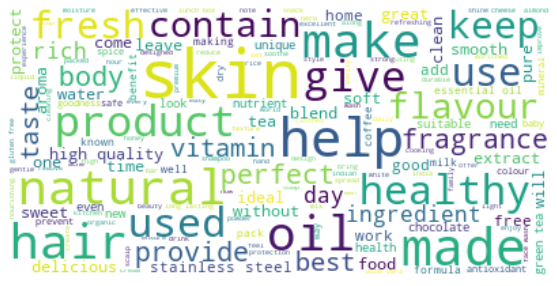

cluster: 12


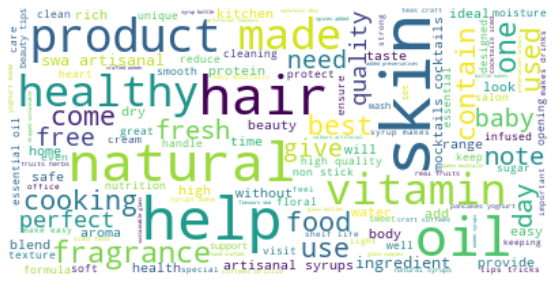

cluster: 13


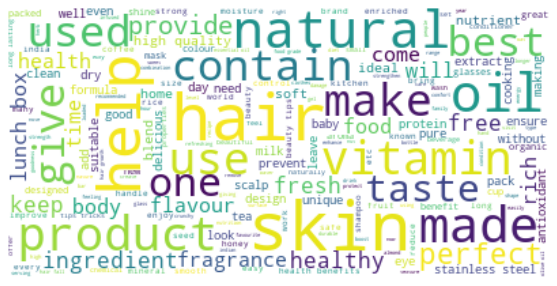

cluster: 14


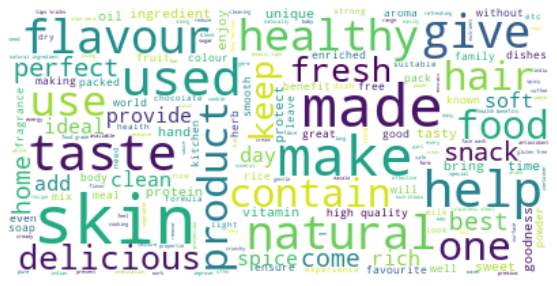

In [92]:
#https://pypi.org/project/wordcloud/
#http://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html
# building word clouds for clusters
from wordcloud import WordCloud
cloud_data=df[['description','cluster_label']] # selecting text data of description column used for clustering and label column
for i in range(0,best_k):
    text=cloud_data[cloud_data['cluster_label']==i] # grouping(selecting) data with same label 
    text=text['description'].str.cat(sep=' ') # selecting column 'description' from same cluster labels
    text=' '.join(word for word in text.split())
    wordcloud=WordCloud(background_color='white',max_font_size=50).generate(text)
    wordcloud.to_file('./wordcloud_images/cluster'+str(i)+'.jpg') # saving wordcloud images
    print('cluster:',format(i))
    
    plt.figure()
    plt.imshow(wordcloud,interpolation="bilinear")
    plt.axis("off")
    plt.show()
    

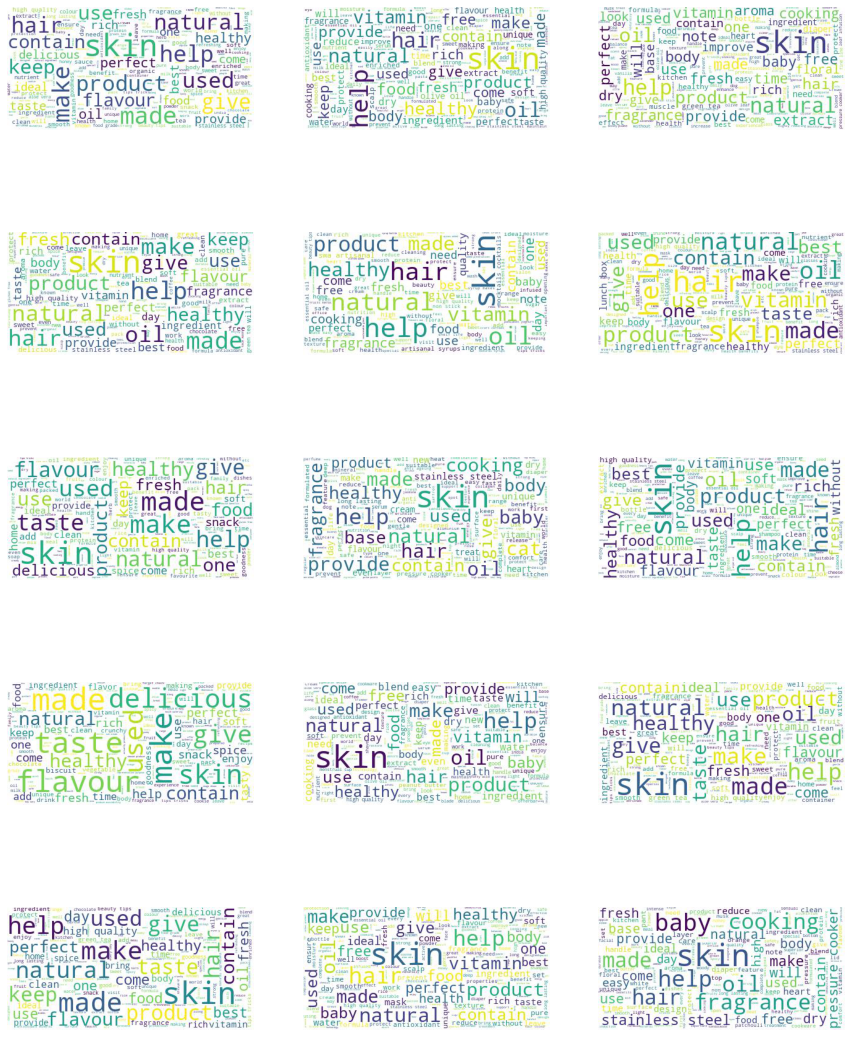

In [93]:
# to show wordcloud images
#https://kanoki.org/2021/05/11/show-images-in-grid-inside-jupyter-notebook-using-matplotlib-and-numpy/
#https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html
%matplotlib inline
import os
from PIL import Image

images=os.listdir('./wordcloud_images') # returns a list of all image titles in wordcloud_images folder

rows=5
cols=3
img_count = 0

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15,20))

for i in range(rows):
    for j in range(cols):        
        if img_count < len(images):
            image=plt.imread('./wordcloud_images/'+images[img_count])
            axes[i, j].imshow(image)
            axes[i,j].axis("off") # to remove axis ticks
            img_count+=1


- From wordcloud we see that products with similar usage like kitchen utensils, food items,face soaps,tea, health suppliments,  etc are grouped together
- will use the cluster label in computing similarity between products

### <U/> References

- https://www.geeksforgeeks.org/
- https://seaborn.pydata.org/generated/seaborn
- https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
- https://docs.python.org/3/library/re.html
- https://www.towardsdatascience.com/